# Задача 1: "Гипершар"

Класс занимает  $n$-мерный шар в центре гиперкуба. Вокруг него (внутри куба) - второй класс.<br> 
Сколько минимум должно быть нейронов в скрытом слое?<br> 
Обучить сеть для  $n=3$. Какая проблема возникает при больших  $n$?

## Прямая генерация данных

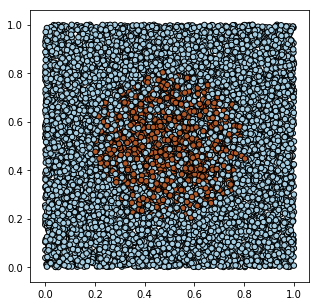

samples: [8741 1259]
(10000, 3) (10000,)
(9000, 3) (9000,)
(1000, 3) (1000,)


In [106]:
import numpy as np                            # работа с массивами
import matplotlib.pyplot as plt               # постороение графиков
import time                                   # время вычислений

n_dim = 3                                     # размерность пространства
n_dat = 10000                                  # число примеров обоих классов

np.random.seed(0)                             # создаём данные 
x = np.random.rand(n_dat, n_dim)              # с двумя признаками и двумя классами
y = np.sum( (x-0.5)**2, axis=1 ) < 0.1        # дырка

plt.subplots(figsize=(5, 5));                 # размеры картинки (квадрат)
plt.scatter(x[:,0], x[:,1], s=30, c=y, cmap=plt.cm.Paired, edgecolors='k')        
plt.show()                     

n_lrn = round(len(y)*0.9)                     # число данных для обучения (90%)
x_lrn = x[:n_lrn]; y_lrn = y[:n_lrn]          # разбиваем на данные для обучения
x_val = x[n_lrn:]; y_val = y[n_lrn:]          # и проверочные (валидационные)

print("samples:", np.bincount(y))             # количество разный целых чисел
print(x.shape, y.shape)
print(x_lrn.shape, y_lrn.shape)
print(x_val.shape, y_val.shape)

<b>Проблема</b>: при больших $n$ число точек, попадающих внутрь шара становится очень мало (гипершар имеет очень маленький объём). Поэтому стоит изменить способ генерации данных.

## Генерация сбалансированных данных

Создаём сначала случайно направленные единичные векторы `vec`.<br> 
С их помощью получаем сферический слой радиуса `r` толщиной `2*dr`.<br>
Для вменяемой картинки, стоит поставить сначала `n_dim=2`

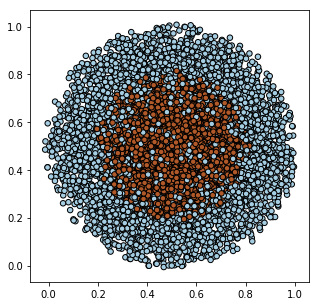

samples: [5027 4973]
(9000, 3) (9000,)
(1000, 3) (1000,)


In [115]:
n_dim = 3                                     # размерность пространства
n_dat = 10000                                 # число примеров обоих классов
r     = 0.1**0.5                              # радиус сферического слоя
dr    = 0.2                                   # половина его толщины

np.random.seed(0)                             # Создаём данные 
vec  = np.random.normal(size=(n_dat, n_dim))  # n_dat случайных n_dim - мерных векторов
norm = np.linalg.norm(vec, axis=1)            # их длины
vec  = vec / norm.reshape(len(norm),1)        # единичные [[x1,x2,x3],...] / [[norm],...]

x    = 0.5 + vec * np.random.uniform(r-dr,r+dr, size=(n_dat, 1))
y    = np.sum( (x-0.5)**2, axis=1 ) < r*r     # дырка

plt.subplots(figsize=(5, 5));                 # размеры картинки (квадрат)
plt.scatter(x[:,0], x[:,1], s=30, c=y, cmap=plt.cm.Paired, edgecolors='k')        
plt.show()                     

n_lrn = round(len(y)*0.9)                     # число данных для обучения (90%)
x_lrn = x[:n_lrn]; y_lrn = y[:n_lrn]          # разбиваем на данные для обучения
x_val = x[n_lrn:]; y_val = y[n_lrn:]          # и проверочные (валидационные)

print("samples:", np.bincount(y))             # количество разный целых чисел
print(x_lrn.shape, y_lrn.shape)
print(x_val.shape, y_val.shape)

## Определяем модель

В $n$-мерном пространстве шар можно окружить симплексом, имеющим $n+1$ плоскостей.<br>
Поэтому минимальная сеть, отделяющая два класса должна иметь один скрытый слой с $n+1$ числом нейронов.

In [119]:
from   keras             import backend as K
from   keras.models      import Sequential, load_model
from   keras.layers      import Dense
from   keras.optimizers  import SGD, Adadelta
from   keras.callbacks   import ModelCheckpoint

K.clear_session()                                         # сброс номеров имён слоёв
model = Sequential()                                      # линейная стопка слоёв
model.add(Dense(n_dim+1, activation = 'sigmoid',  input_dim=n_dim)) 
model.add(Dense(1, activation = 'sigmoid'))               # выходной слой

model.summary()          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


## Обучаем модель

Используем стохастический градиентный спуск с переменной скоростью обучения

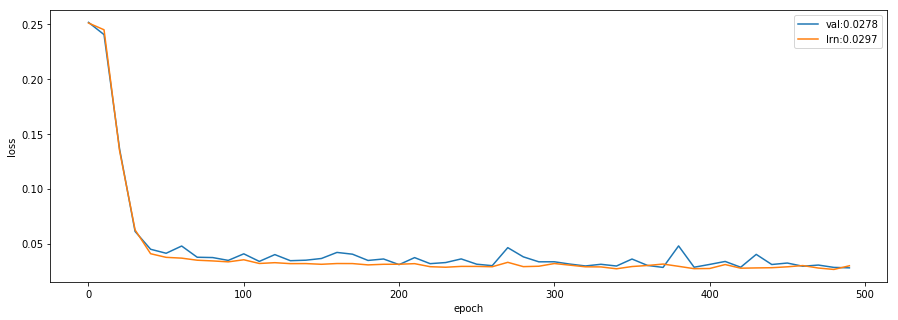

Wall time: 45.3 s


In [120]:
%%time

batch   = 100          # размер пачки
epochs  = 500          # число эпох обучения
lr_init = 1            # начальное значение скорости обучения
lr_fin  = 0.5          # финальная скорость обучения
steps   = int(len(y_lrn) / batch) * epochs
decay   = (lr_init/lr_fin)**(1/(steps-1)) - 1

model.compile(loss      = 'mean_squared_error',   # функция ошибок
              optimizer = SGD(lr=1, momentum=0.8, decay=decay),
              metrics   = ['accuracy'])           # вычисл.метрики

plot_losses.reset = True                          # очищаем или нет график ошибок
plot_losses.plot  = False                         # показываем только график ошибки

model.fit(x_lrn, y_lrn, validation_data=(x_val, y_val),
          batch_size = batch, epochs = epochs,  verbose=0, 
          callbacks=[plot_losses])

## Тестируем

In [121]:
%%time
score = model.evaluate(x_lrn, y_lrn, verbose=0)
print('lrn loss: %.4f, acc: %.4f' % (score[0], score[1]) )

score = model.evaluate(x_val, y_val, verbose=0)
print('val loss: %.4f, acc: %.4f' % (score[0], score[1]) )

lrn loss: 0.0259, acc: 0.9653
val loss: 0.0284, acc: 0.9640
Wall time: 160 ms


# Задача  2: Шахматная доска

Пространство признаков - двумерный квадрат $[0...1]^2$. Оно разбито на чёрно-белые клетки 4x4. В белых клетках класс 0, в чёрных 1. Сколько скрытых слоёв должно быть в сети? Какое минимальное число нейронов в них? Обучить "минимальную" сеть и сеть с удвенным числом нейронов.

## Генерация данных

Случайно заполняем квадрат $[0...1]^2$ точками. Координаты точек ($x_1,x_2$) переводим в целые числа 0,1,2,3, умножив на число клеток в строке `n_sqrs = 4`. Клетки одного цвета соответствуют равенству $x_1$ % 2 == $x_2$ % 2 (остатки от деленния на 2). 

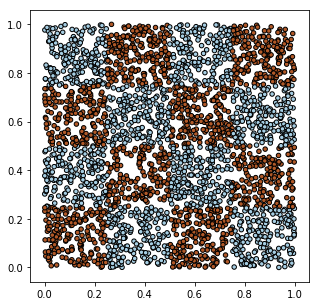

In [99]:
import numpy as np                            # работа с массивами
import matplotlib.pyplot as plt               # постороение графиков
import time                                   # время вычислений

n_sqrs = 4                                    # размер доски (клеток в строке)
np.random.seed(1)                             # Создаём данные с двумя признаками 
x = np.random.rand(3000, 2)                   # 1200 случайных чисел [0..1]^2
y = np.mod(np.floor(x[:,0]*n_sqrs), 2)  == np.mod(np.floor(x[:,1]*n_sqrs), 2)      

plt.subplots(figsize=(5, 5));                 # размеры картинки (квадрат)
plt.scatter(x[:,0], x[:,1], s=20, c=y, cmap=plt.cm.Paired, edgecolors='k')        
plt.show()

n_lrn = round(len(y)*0.9)                     # число тренеровочных данных (90%)
x_lrn = x[:n_lrn]; y_lrn = y[:n_lrn]          # разбиваем на тренировочные  
x_val = x[n_lrn:]; y_val = y[n_lrn:]          # и валидационные данные

## Определяем модель

Клетки можно разделить 3-я линиями по горизонтали и 3-я по вертикали. 
Попадание в клетку это логическое И для 4-х плоскостей (линий) внутри доски, 3-х на границе и 2-х в углах. Выходной нейрон делает логическое ИЛИ по клеткам одного цвета. Поэтому минимальная архитектура состоит из двух скрытых слоёв. В первом 6 нейронов, а во втором 8 (по числу клеток одного цвета. 

Однако такая сеть учится достаточно долго, поэтому стоит удвоить число нейронов.<br>
Для борьбы с переобучением можно попробовать добавить  `Dropout` слои.

In [100]:
from   keras.models          import Sequential            # способ формирования слоёв (стопка)
from   keras.layers          import Dense,Dropout         # полносвязный слой
from   keras.optimizers      import SGD                   # метод оучения (стох.град.спуск)
from   keras                 import backend as K          # доступ к настройкам

K.clear_session()                                         # сброс номеров имён слоёв
model = Sequential()                                      # линейная стопка слоёв

model.add(Dense(12, activation = 'sigmoid', input_dim=2)) # входной слой и первый скрытый
#model.add(Dropout(0.1))
model.add(Dense(16, activation = 'sigmoid'))              # dвторой скрытый слой
#model.add(Dropout(0.25))
model.add(Dense(1, activation  = 'sigmoid'))              # выходной слой

model.summary()                                           # описание слоёв

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                36        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                208       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


## Обучаем

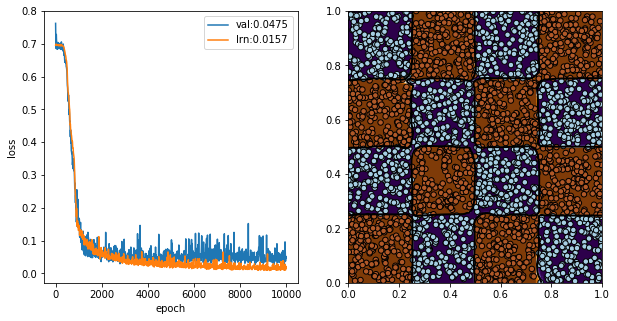

Wall time: 19min 23s


In [101]:
%%time
plot_losses.reset = True                           # очищаем или нет график ошибок
plot_losses.plot  = True                           # показываем график ошибки и данные

model.compile(loss      = 'binary_crossentropy',   # функция ошибок ('mean_squared_error')
              optimizer = SGD(lr=0.5, momentum=0.8), # метод её оптимизации (10, 0.1)
              metrics   = ['accuracy'])            # вычисл.метрики


model.fit(x_lrn, y_lrn, validation_data=(x_val, y_val),
          batch_size = 100, epochs = 10000,  verbose=0, 
          callbacks=[plot_losses])

In [105]:
model.save("chess_12_16.h5")

In [104]:
from keras.models import load_model
#%time model = load_model("chess_12_16.h5")   # загружаем сеть из файла

score = model.evaluate(x_lrn, y_lrn, verbose=0)
print('lrn: loss: %.4f, acc: %.4f' % (score[0], score[1]) )

score = model.evaluate(x_val, y_val, verbose=0)
print('val: loss: %.4f, acc: %.4f' % (score[0], score[1]) )

lrn: loss: 0.0077, acc: 0.9974
val: loss: 0.0399, acc: 0.9833


# Вспомогательные функции
## График ошибки и разделяющая поверхность

In [5]:
# Карта расстояний от плоскости, уровни линий, данные и опорные векторы
def plot(model, x, y, xMin=0, xMax=1, levels=[0.5]): 
    # сетка точек 201 x 201 в интервале x1,x2=[xMin,xMax]
    x1,x2 = np.meshgrid(np.linspace(xMin,xMax,201),np.linspace(xMin,xMax,201))
    grid  = np.c_[x1.ravel(), x2.ravel()]
    
    # Вычисляем в точках сетки расстояния до разделяющей плоскости:
    yp = model.predict(grid).reshape(x1.shape)
    
    #fig,ax = plt.subplots(figsize=(5, 5));    # размеры картинки (квадрат!)
    plt.axis([xMin, xMax, xMin, xMax])        # диапазон изменения осей

    plt.imshow(yp, interpolation='nearest',   # цвет. карту для 2D массива yp
                   extent=(x1.min(), x1.max(), x2.min(), x2.max()), 
                   aspect='auto', origin='lower', 
                   vmin=xMin, vmax=xMax, cmap=plt.cm.PuOr_r)

    plt.contour(x1,x2, yp, # линии yp = levels                
                levels=levels, linewidths=2, colors=['k', 'k', 'k'],   
                linestyles= ['--', '-', '--'] if len(levels)==3 else ['-'])
    plt.scatter(x[:,0], x[:,1], s=30, c=y, cmap=plt.cm.Paired,edgecolors='k')
            
#---------------------------------------------------------------------------------------------    
# updatable plot
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    skip      = 10                               # число эпох между выводом графика
    reset     = False                            # очищать историю
    plot      = True                             # рисовать ли данные
    i         = 0
    
    def on_train_begin(self, logs={}):           # запустится один раз в начале
        if self.reset or self.i==0: 
            self.i = 0                           # номер точки
            self.x = []                          # значения x-ов графика
            self.losses = []                     # значения y-ков графика для train
            self.val_losses = []                 # значения y-ков графика для test
            self.fig = plt.figure()              
            self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.skip == 0:            
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append    (logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.i += self.skip
        
            clear_output(wait=True)
            if self.plot:
                plt.subplots(1,2, figsize=(10, 5) )
                plt.subplot (1, 2, 1)
            else:
                plt.subplots(figsize=(15, 5))
            plt.plot(self.x, self.val_losses, label="val:{0:.4f}".format(self.val_losses[-1]) )
            plt.plot(self.x, self.losses,     label="lrn:{0:.4f}".format(self.losses[-1]) )            
            plt.ylabel('loss'); plt.xlabel('epoch')
            plt.legend()            
            if self.plot:
                plt.subplot(1, 2, 2);
                plot(model,x,y);
            plt.show();    

plot_losses = PlotLosses()    